In [ ]:
# Import libraries
import os
import pandas as pd
import whisper
import torch
import torchaudio
import torchaudio.transforms as T
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [ ]:
# Set up device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Load Whisper model once
whisper_model = whisper.load_model("small")

# Load VAD model from Silero
vad_model, utils = torch.hub.load(
    repo_or_dir="snakers4/silero-vad",
    model="silero_vad",
    force_reload=True
)
(get_speech_timestamps, _, _, _, _) = utils

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_locatio

In [4]:
class ProcessAudioFiles:

    """
    A class to process bird audio recordings in .ogg format. It performs the following:
    - Splits audio files into 5-second chunks
    - Detects human speech using VAD and Whisper
    - Filters out repetitive or short speech content
    - Saves chunks into train/validation directories based on presence of human voice
    - Builds a mapping from numeric labels to species information

    Args:
        input_csv (str): Path to the CSV file containing metadata.
        data_folder (str): Root folder containing the audio files organized by species label.
        output_base (str): Base path where processed data will be saved.
        chunk_duration (int): Duration of each audio chunk in milliseconds.
        validation_ratio (float): Proportion of data to be used for validation.
        min_unique_ratio (float): Minimum ratio of unique words in transcribed speech to accept it.
        min_word_count (int): Minimum number of words in speech for it to be considered valid.
        seed (int): Random seed for data splitting.
    """

    def __init__(
            self,
            input_csv: str=None,
            data_folder: str=None,
            output_base: str=None,
            discard_human_voice: bool=True,
            chunk_duration: int=5000,
            validation_ratio: float=0.2,
            min_unique_ratio: float=0.5,
            min_word_count: int=3,
            seed: int=42
            ):
        
        super().__init__()
        self.input_csv = input_csv
        self.data_folder = data_folder
        self.output_base = output_base
        self.output_base_human = f"{output_base}_human"
        self.discard_human_voice = discard_human_voice
        self.chunk_duration = chunk_duration
        self.validation_ratio = validation_ratio
        self.min_unique_ratio = min_unique_ratio
        self.min_word_count = min_word_count
        self.seed = seed
    
    
    def is_repetitive(self, text):

        """
        Checks if a transcribed text contains too much repetition or too few unique words.

        Args:
            text (str): The transcribed speech.

        Returns:
            bool: True if the text is repetitive or empty, False otherwise.
        """

        words = text.lower().split()
        if not words:
            return True
        unique_words = set(words)
        return (len(unique_words) / len(words)) < self.min_unique_ratio
        
    def contains_human_voice(self, audio_path):

        """
        Detects human voice in an audio file using Voice Activity Detection (VAD) and Whisper.

        Args:
            audio_path (str): Path to the audio file.

        Returns:
            tuple: (bool indicating presence of human voice, transcribed text if available).
        """

        wav, sr = torchaudio.load(audio_path)

        # Resample to 16kHz for VAD if needed (but keep the original sampling rate for export)
        if sr != 16000:
            resampler = T.Resample(orig_freq=sr, new_freq=16000)
            wav_for_vad = resampler(wav)
        else:
            wav_for_vad = wav

        # Run VAD
        speech_timestamps = get_speech_timestamps(wav_for_vad, vad_model, sampling_rate=16000)

        # No speech-like pattern found at all
        if len(speech_timestamps) == 0:
            return False, ""

        # Transcribe with Whisper
        result = whisper_model.transcribe(audio_path, language="es")
        text = result.get("text", "").strip()

        # Check if text is long enough and not just repetition
        if len(text.split()) >= self.min_word_count and not self.is_repetitive(text):
            return True, text
        return False, text
    
    def process_and_save(self, row, split, labels):
        
        """
        Processes a single row (audio sample) from the dataset:
        - Loads audio
        - Splits it into fixed-length chunks
        - Checks each chunk for human voice
        - Saves it in the appropriate folder: _human or _animal

        Args:
            row (pd.Series): A row from the CSV containing metadata for the audio file.
            split (str): Whether the file belongs to 'train' or 'validation'.
            labels (list): List of unique label strings used for mapping to numeric indices.
        """

        label = row['primary_label']
        file_name = row['filename']
            
        # Construct the full file path correctly
        file_path = os.path.join(self.data_folder, label, os.path.basename(file_name))

        # Ensure all slashes are forward slashes
        file_path = file_path.replace("\\", "/")

        # If file path is invalid, print error and return
        if not os.path.exists(file_path):
            print(f"File does not exist: {file_path}")
            return

        try:
            # Load the .ogg file using pydub (pydub supports ogg if ffmpeg is installed)
            audio = AudioSegment.from_file(file_path, format="ogg")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            return
        
        # Determine the number of chunks
        num_chunks = max(1, len(audio) // self.chunk_duration)
        
        # Process each chunk
        for i in range(num_chunks):
            start_ms = i * self.chunk_duration
            end_ms = start_ms + self.chunk_duration
            chunk = audio[start_ms:end_ms]
            
            # Check if the chunk is shorter than the desired duration
            if len(chunk) < self.chunk_duration:
                # Calculate the difference and pad with silence
                silence_duration = self.chunk_duration - len(chunk)
                silence = AudioSegment.silent(duration=silence_duration)
                chunk = chunk + silence  # Pad with silence at the end

            # Find the numeric index of the current label
            numeric_label = labels.index(label) 
            
            # Use the numeric index for folder creation
            base_dir = os.path.join(self.output_base, split, str(numeric_label))
            os.makedirs(base_dir, exist_ok=True)

            output_file = os.path.join(base_dir, f"{os.path.splitext(os.path.basename(file_name))[0]}_chunk{i}.wav")
            
            # Create the directory where the file will be saved if it doesn't exist
            os.makedirs(os.path.dirname(output_file), exist_ok=True)
            
            # Export chunk as .wav (or you can export as .ogg if desired)
            chunk.export(output_file, format="wav")
            
            # Check for human voice
            human_voice, _ = self.contains_human_voice(output_file)

            # Move to "data_human" folder
            if self.discard_human_voice and human_voice:    
                human_base_dir = os.path.join(self.output_base_human, split, str(numeric_label))
                os.makedirs(human_base_dir, exist_ok=True)
                human_output_file = os.path.join(human_base_dir, f"{os.path.splitext(os.path.basename(file_name))[0]}_chunk{i}.wav")                
                os.rename(output_file, human_output_file)
    
    def create_audio_chunks(self):

        """
        Main method to process all audio files from CSV:
        - Reads metadata
        - Splits into train/validation
        - Creates directory structure
        - Processes each file and saves cleaned, chunked output

        Returns:
            dict: Mapping of numeric labels to species metadata (label, scientific_name, common_name).
        """

        # Read CSV file
        df = pd.read_csv(self.input_csv)
        
        # Create a mapping from numeric label to species information (idx, label, scientific_name, common_name)
        labels = sorted(df['primary_label'].unique())
        
        # Create the dictionary mapping numeric labels (0, 1, 2, ...) to species information
        label_to_info = {
            i: {
                'label': label,
                'scientific_name': df[df['primary_label'] == label]['scientific_name'].iloc[0],  # Adjust column name if needed
                'common_name': df[df['primary_label'] == label]['common_name'].iloc[0]  # Adjust column name if needed
            }
            for i, label in enumerate(labels)
        }
        
        # Split dataframe into training and validation sets
        train_df, val_df = train_test_split(
            df,
            test_size=self.validation_ratio,
            stratify=df['primary_label'],
            random_state=self.seed)
        
        # Create directory structure using numeric labels
        for split in ['train', 'validation']:
            base_dir = os.path.join(self.output_base, split)
            os.makedirs(base_dir, exist_ok=True)
            for numeric_label in range(len(labels)):
                label_name = label_to_info[numeric_label]['label']  # Get the species label for the numeric index
                os.makedirs(os.path.join(base_dir, str(numeric_label)), exist_ok=True)  # Create folder with numeric index

            
        # Track progress for the entire dataset processing
        with tqdm(total=len(train_df) + len(val_df), desc="Processing Files", unit="file") as pbar:
            
            # Process training files
            for _, row in train_df.iterrows():
                self.process_and_save(row, 'train', labels)
                pbar.update(1)
                
            # Process validation files
            for _, row in val_df.iterrows():
                self.process_and_save(row, 'validation', labels)
                pbar.update(1)
        
        # Return the dictionary mapping numeric labels to species information
        return label_to_info

    def __call__(self):
        return self.create_audio_chunks()

In [5]:
# Set your paths
input_csv = r"D:/Repos/birdclef-2025/train.csv"
data_folder = r"D:/Repos/birdclef-2025/train_audio"
output_base = "data"

label_to_info = ProcessAudioFiles(
    input_csv=input_csv,
    data_folder=data_folder,
    output_base=output_base
)()

Processing Files:   0%|          | 0/28564 [00:00<?, ?file/s]

In [6]:
def count_files(base_folder):
    """
    This function analyzes the 'train' and 'validation' subfolders within a given base folder,
    counts the number of files for each label in both subfolders, and returns a DataFrame for each.

    Args:
        base_folder (str): The root directory containing 'train' and 'validation' subfolders.

    Returns:
        tuple: A tuple containing two DataFrames: one for 'train' and one for 'validation',
               with columns 'label' and 'num_files'.
    """
    # Initialize dictionaries to hold the file counts for 'train' and 'validation'
    train_counts = {}
    val_counts = {}

    # Loop through the 'train' and 'validation' subfolders
    for split in ['train', 'validation']:
        split_folder = os.path.join(base_folder, split)
        
        if not os.path.exists(split_folder):
            print(f"Warning: {split_folder} does not exist.")
            continue

        # Loop through the label folders in the subfolder (assuming labels are numeric)
        for label_folder in os.listdir(split_folder):
            label_path = os.path.join(split_folder, label_folder)
            
            # Only process directories (which represent labels)
            if os.path.isdir(label_path):
                # Count the number of files in the directory (ignoring subdirectories)
                num_files = len([f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))])

                # Store the result in the appropriate dictionary
                if split == 'train':
                    train_counts[int(label_folder)] = num_files
                elif split == 'validation':
                    val_counts[int(label_folder)] = num_files

    # Convert the dictionaries into DataFrames
    df_train = pd.DataFrame(list(train_counts.items()), columns=['label', 'num_files'])
    df_val = pd.DataFrame(list(val_counts.items()), columns=['label', 'num_files'])

    return df_train, df_val

In [7]:
df_train, df_val = count_files(output_base)

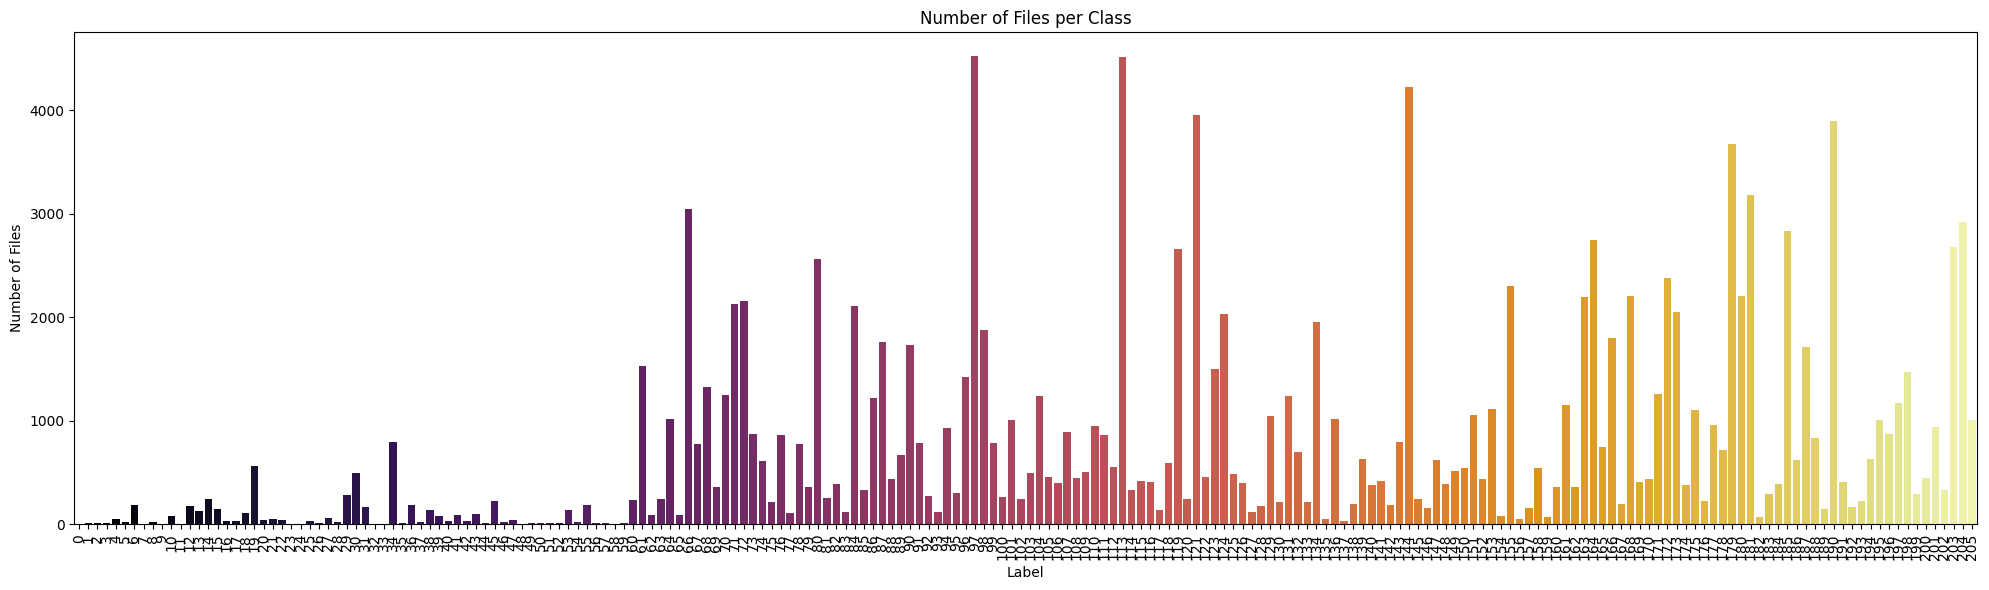

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the bar plot using seaborn
plt.figure(figsize=(20, 6))  # Set the figure size
sns.barplot(x='label', hue='label', y='num_files', data=df_train, legend=False, palette='inferno')

# Adding labels and title
plt.title('Number of Files per Class')
plt.xlabel('Label')
plt.ylabel('Number of Files')

# Rotate x-axis labels if they are too long
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [10]:
print(f"Maximum number of files in a class: {df_train['num_files'].max()}")

Maximum number of files in a class: 4529


In [ ]:
# Now you can print or use the label_to_info dictionary
print(label_to_info)

In [ ]:
df = pd.DataFrame(label_to_info)

In [ ]:
dft = df.T

In [ ]:
dft

In [ ]:
dft.to_csv('label_to_info.csv')

In [ ]:
import os
import shutil
import random

output_base = "data"
train_dir=f'{output_base}/train'
val_dir=f'{output_base}/validation'
val2_dir=f'{output_base}/validation2'
classes = sorted(os.listdir(train_dir))
for cls in classes:
    
    train_cls_path = os.path.join(train_dir, cls)
    val_cls_path = os.path.join(val_dir, cls)
    val2_cls_path = os.path.join(val2_dir, cls)

    # Skip non-directories (just in case)
    if not os.path.isdir(train_cls_path):
        continue

    # Check if validation folder has any files
    val_files = [f for f in os.listdir(val_cls_path) if f.endswith('.wav')]

    if len(val_files) == 0:

        # Get train files
        train_files = [f for f in os.listdir(train_cls_path) if f.endswith('.wav')]

        if len(train_files) > 2:

            # Randomly choose one file to move
            os.makedirs(val2_cls_path, exist_ok=True)
            selected_file = random.choice(train_files)
            src_path = os.path.join(train_cls_path, selected_file)
            dst_path = os.path.join(val_cls_path, selected_file)
            dst2_path = os.path.join(val2_cls_path, selected_file)

            # Move the file
            shutil.copy(src_path, dst2_path)

            print(f"[✓] Copied '{selected_file}' from train/{cls} → validation2/{cls}")

[✓] Copied 'iNat297879_chunk1.wav' from train/10 → validation/10
[✓] Copied 'XC959831_chunk17.wav' from train/20 → validation/20
[✓] Copied 'iNat155127_chunk0.wav' from train/23 → validation/23
[✓] Copied 'iNat557906_chunk1.wav' from train/24 → validation/24
[✓] Copied 'iNat68676_chunk9.wav' from train/26 → validation/26
[✓] Copied 'CSA35461_chunk41.wav' from train/27 → validation/27
[✓] Copied 'CSA36359_chunk1.wav' from train/33 → validation/33
[✓] Copied 'CSA18218_chunk43.wav' from train/39 → validation/39
[✓] Copied 'iNat14973_chunk1.wav' from train/48 → validation/48
[✓] Copied 'iNat40682_chunk5.wav' from train/49 → validation/49
[✓] Copied 'iNat315496_chunk4.wav' from train/50 → validation/50
[✓] Copied 'iNat594579_chunk2.wav' from train/52 → validation/52
[✓] Copied 'iNat737012_chunk5.wav' from train/57 → validation/57
